# Hate Speech Classification using Logistic Regression

# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
from rabbit import Rabbit
import sentencepiece as spm
import collections
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

# Load the dataset

In [2]:
df = pd.read_csv('data/hate_speech.csv')
df.shape

(15653, 13)

In [3]:
df.describe(include = 'all')

Post_Link    Profile_ID  \
count                                               15499  1.565300e+04   
unique                                                 36           NaN   
top     https://www.facebook.com/groups/39208288802014...           NaN   
freq                                                  493           NaN   
mean                                                  NaN  9.982731e+13   
std                                                   NaN  1.613722e+13   
min                                                   NaN  5.447548e+08   
25%                                                   NaN  1.000114e+14   
50%                                                   NaN  1.000215e+14   
75%                                                   NaN  1.000300e+14   
max                                                   NaN  7.049763e+14   

        Profile_Name    Comment_ID  Comment_Group Comment_Group_Number   Text  \
count          15653  1.565200e+04   10056.000000                 5597  15653   
unique          9680           NaN            NaN                 2613  15178   
top     Kaung Si Thu           NaN            NaN                  3-1      .   
freq             211           NaN            NaN                   16     27   
mean             NaN  1.022794e+15     170.127387                  NaN    NaN   
std              NaN  9.036408e+14     111.892358                  NaN    NaN   
min              NaN  1.001650e+14       1.000000                  NaN    NaN   
25%              NaN  3.874190e+14      76.000000                  NaN    NaN   
50%              NaN  5.450410e+14     156.000000                  NaN    NaN   
75%              NaN  1.625447e+15     252.000000                  NaN    NaN   
max              NaN  3.728517e+15     489.000000                  NaN    NaN   

           Encoding Lexicon         Label Collector_Clarifications  \
count   8880.000000    6293  15653.000000                      572   
unique          NaN    5346           NaN                      328   
top             NaN   အဖုတ္           NaN                        ?   
freq            NaN      54           NaN                      177   
mean       0.915991     NaN      0.404651                      NaN   
std        0.563296     NaN      0.490840                      NaN   
min        0.000000     NaN      0.000000                      NaN   
25%        1.000000     NaN      0.000000                      NaN   
50%        1.000000     NaN      0.000000                      NaN   
75%        1.000000     NaN      1.000000                      NaN   
max        2.000000     NaN      1.000000                      NaN   

           Collector_Name   Reviewer_Name  
count               15160            2143  
unique                  7               1  
top     Sai Aung Myo Htet  Phyu Zin Thant  
freq                 9420            2143  
mean                  NaN             NaN  
std                   NaN             NaN  
min                   NaN             NaN  
25%                   NaN             NaN  
50%                   NaN             NaN  
75%                   NaN             NaN  
max                   NaN             NaN

# Explore the data

Text(0.5, 1.0, 'Label')

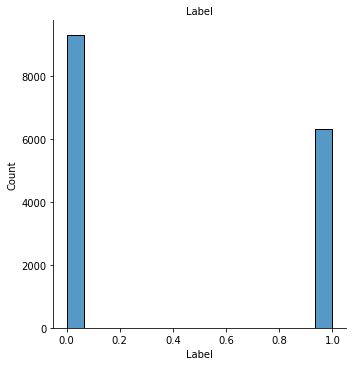

In [4]:
sns.displot(df['Label'])
plt.title('Label', size = 10)

# Preprocessing

In [5]:
df.isnull().sum()

Post_Link                     154
Profile_ID                      0
Profile_Name                    0
Comment_ID                      1
Comment_Group                5597
Comment_Group_Number        10056
Text                            0
Encoding                     6773
Lexicon                      9360
Label                           0
Collector_Clarifications    15081
Collector_Name                493
Reviewer_Name               13510
dtype: int64

In [6]:
df['Text'].shape, df['Label'].shape

((15653,), (15653,))

In [7]:
#Remove punctuation
RE_PUNC = re.compile('[.!"#$%&\'()*+,-./:;။၊<=>?@[\\]^_{|}~`]')

#Remove url link
RE_URL = re.compile(r'http\S+')

#Remove the space 
RE_SPACE = re.compile(r"\s+")

#Remove zero width space
RE_ZWS = ('\u200b')

def cleantext(text):
    '''
    input: string
    
    return: the clean text
    
    '''
    text = re.sub(RE_SPACE,'',text)
    text = re.sub(RE_PUNC, '', text) 
    text = re.sub(RE_URL, '', text)
    text = re.sub(RE_ZWS, '', text)
    
    return text    

In [8]:
#Apply clean text function
df['Text'] = df['Text'].apply(cleantext)

In [9]:
#Convert zawgyi to unicode texts
hs_list = list()
for line in df['Text']:
    hs_list.append(Rabbit.zg2uni(line))

# Tokenization

In [10]:
with open('corpus.txt', 'w') as f:
    f.writelines(f'{line}\n' for line in hs_list)

In [11]:
voc_size = [5000]

for voc_size in voc_size:
    spm.SentencePieceTrainer.Train('--input=corpus.txt'
                                f' --model_prefix=spm'
                                f' --vocab_size={voc_size}'
                                ' --model_type=bpe'
                                ' --split_by_whitespace=true')

In [12]:
#Load sentencepiece model

sp = spm.SentencePieceProcessor()
sp.Load('spm.model')

True

In [13]:
df['sp_text'] = [sp.EncodeAsPieces(x) for x in hs_list] 

df['sp_text'].head()

0                     [▁အားပေး, နေ, ပါ့, မယ်နော်, 😁😁😁]
1    [▁, ဖြေးဖြေး, ဆို, ပါ, ဟယ်, ph, screen, ကြီးလဲ...
2              [▁သ, ဘော, အကျ, ဆုံး, ဘဲ, ကိုက, ယား, ရေ]
3                     [▁Myat, Min, Thu, ကျေးဇူးပါ, ဗျ]
4                  [▁McKaYahLay, add, ပေး, ဦး, းး, လေ]
Name: sp_text, dtype: object

# Count the tokenized words

In [14]:
# Count the frequency of each word
words_count = []

for sent in df['sp_text']:
     for word in sent:
        words_count.append(word)
    
words_count = collections.Counter(words_count)  

In [15]:
# Count the labels
labels_count = []

for label in df['Label']:
    labels_count.append(label)

labels_count =  collections.Counter(labels_count) 

labels_count

Counter({0: 9319, 1: 6334})

# Split the data into train, test and validation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['sp_text'], df['Label'], test_size = 0.1)

In [17]:
X_train.shape, y_train.shape

((14087,), (14087,))

In [18]:
X_test.shape, y_test.shape

((1566,), (1566,))

# Bag of Word - text representation model

In [19]:
# Count the most common words
dic_size = 3000
vocabulary = words_count.most_common(dic_size)

In [20]:
word2index = {item[0]:ii for ii, item in enumerate(sorted(vocabulary, key=lambda x: x[1], reverse=True))}

In [21]:
index2word = {i:item for item,i in word2index.items()}

In [22]:
def bag_of_word(text, word2index, dic_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    
    #Create a zero vector with the dimension of dictionary
    result_vector = np.zeros(dic_size)
    
    for word in text:
        if word in word2index:
            result_vector[word2index[word]] = 1  #if each syllable is in the dictionary, represented by 1
            print(result_vector)
            
    return result_vector

In [23]:
X_train_bag = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_word(text, word2index, dic_size)) for text in X_train])

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 1. 0. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0. 0. 1.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0. 0. 0.]
[1. 1. 1. ... 0.

[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[1. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

In [24]:
X_test_bag = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_word(text, word2index, dic_size)) for text in X_test])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 0. ... 0. 0. 0.]
[1. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0.

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[1. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

# Logistic Regression

In [25]:
# Load the model
lr = LogisticRegression()
lr.fit(X_train_bag, y_train)

LogisticRegression()

In [26]:
# For train
lr.score(X_train_bag, y_train)

0.9214878966422944

In [27]:
# For test
yhat_test = lr.predict(X_test_bag)
yhat_test

array([0, 0, 0, ..., 0, 1, 0])

In [28]:
lr.predict_proba(X_test_bag)

array([[0.82537171, 0.17462829],
       [0.83723335, 0.16276665],
       [0.81334697, 0.18665303],
       ...,
       [0.77553703, 0.22446297],
       [0.28173089, 0.71826911],
       [0.81396212, 0.18603788]])

In [29]:
#For test
accuracy_score(y_test, yhat_test)

0.8461047254150702